In [4]:
# Ignore printing all warnings
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings

# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:

#df = yf.download(ticker, start = _start, end = _end)
df=pd.read_csv("../data/BTC-USD.csv") 

In [14]:
# calculating buy and hold strategy returns
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,bnh_returns
0,2017-10-10,4776.209961,4922.169922,4765.100098,4781.990234,4781.990234,1597139968,NaN
1,2017-10-11,4789.250000,4873.729980,4751.629883,4826.479980,4826.479980,1222279936,0.009261
2,2017-10-12,4829.580078,5446.910156,4822.000000,5446.910156,5446.910156,2791610112,0.120931


In [15]:
# creating bollinger band indicators
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Date,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band
1822,2022-10-06,19955.443359,19955.443359,34711412966,-0.010234,19408.863281,470.936137,20350.735556,18466.991007
1823,2022-10-07,19546.849609,19546.849609,29227315390,-0.020688,19379.826953,441.258124,20262.343201,18497.310706
1824,2022-10-08,19416.568359,19416.568359,16437423167,-0.006687,19379.680078,441.244710,20262.169498,18497.190658
1825,2022-10-09,19446.425781,19446.425781,16837262532,0.001537,19374.794922,439.866922,20254.528765,18495.061079
1826,2022-10-10,19320.189453,19320.189453,25182300160,-0.006513,19396.264941,425.235298,20246.735538,18545.794345


In [16]:
# BUY condition
df['signal'] = np.where( (df['Adj Close'] < df['lower_band']) &
                          (df['Adj Close'].shift(1) >= df['lower_band']),1,0)

# SELL condition
df['signal'] = np.where( (df['Adj Close'] > df['upper_band']) &
                          (df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])
# creating long and short positions 
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

# calculating stretegy returns
df['strategy_returns'] = df['bnh_returns'] * (df['position'])

df.tail(5)

,Date,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
1822,2022-10-06,19955.443359,19955.443359,34711412966,-0.010234,19408.863281,470.936137,20350.735556,18466.991007,0,-1.0,0.010234
1823,2022-10-07,19546.849609,19546.849609,29227315390,-0.020688,19379.826953,441.258124,20262.343201,18497.310706,0,-1.0,0.020688
1824,2022-10-08,19416.568359,19416.568359,16437423167,-0.006687,19379.680078,441.244710,20262.169498,18497.190658,0,-1.0,0.006687
1825,2022-10-09,19446.425781,19446.425781,16837262532,0.001537,19374.794922,439.866922,20254.528765,18495.061079,0,-1.0,-0.001537
1826,2022-10-10,19320.189453,19320.189453,25182300160,-0.006513,19396.264941,425.235298,20246.735538,18545.794345,0,-1.0,0.006513


Buy and hold returns: nan
Strategy returns: nan


<AxesSubplot:>

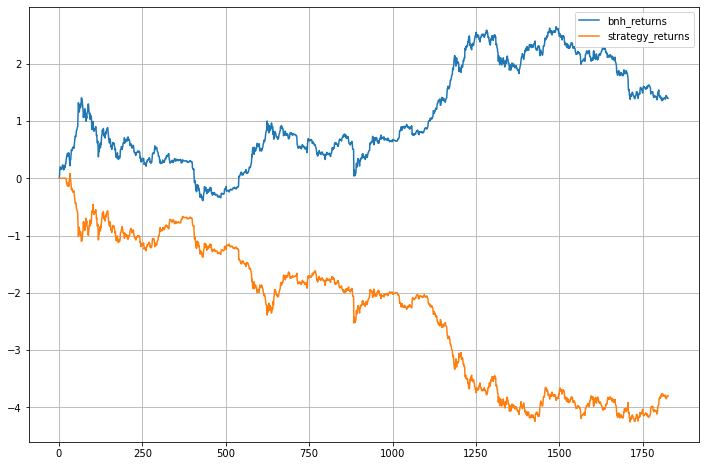

In [21]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and hold returns:",df['bnh_returns'].cumsum()[1])
print("Strategy returns:",df['strategy_returns'].cumsum()[1])

# plotting strategy historical performance over time
df[['bnh_returns','strategy_returns']] = df[['bnh_returns','strategy_returns']].cumsum()
df[['bnh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

In [ ]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())